In [1]:
from __future__ import division

import pandas as pd
from exosyspop.populations import BinaryPopulation
from exosyspop.populations import TRILEGAL_BGBinaryPopulation
from exosyspop.populations import KeplerBinaryPopulation, PoissonPlanetPopulation
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import PopulationMixture

targets = pd.read_hdf('targets.h5')
bgstars = pd.read_hdf('bgstars.h5')

# Sanitize dtypes of targets DataFrame
for c in targets.columns:
    if targets[c].dtype == object:
        targets.loc[:,c] = targets.loc[:,c].astype(str)


import logging
rootLogger = logging.getLogger()

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#pop = KeplerPowerLawBinaryPopulation(targets)
#pop._train_trap()
#pop.save('plaw_pop', overwrite=True)
pop = KeplerPowerLawBinaryPopulation.load('plaw_pop')
pop.set_params(period_min=20, period_max=1200, beta=-0.95, fB=0.14)
catalog = pop.observe(new=True, regr_trap=True)

In [3]:
from exosyspop.survey import DetectionThreshold, DetectionRamp

eff = DetectionRamp(6,16)

In [4]:
pop.params

{'beta': -0.95,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.14,
 'gamma': 0.3,
 'period_max': 1200,
 'period_min': 20,
 'qmin': 0.1}

In [5]:
import sys
sys.path.append('..')

from simpleabc.simple_abc import Model, basic_abc, pmc_abc
from scipy.stats import gaussian_kde, entropy, anderson_ksamp, uniform
import numpy as np

class PopulationModel(Model):
    """
    Test model for stellar binary population where parameters are fB, beta
    """
    def __init__(self, poplist, eff=None):
        self.poplist = poplist     
        self.eff = eff
        self.period_min = poplist.params['period_min']
        self.period_max = poplist.params['period_max']
        
    bounds = [(0,1), (-1.5,0)]
    prior = [uniform(0,1), uniform(-1.5, 1.5)]
        
    def draw_theta(self):
        """ Draw parameters from prior
        """
        return [p.rvs() for p in self.prior]
        
    def generate_data(self, theta):
        """Generates synthetic catalog
        """
        fB, beta = theta
        self.poplist.set_params(fB=fB, beta=beta)
        try:
            return self.poplist.observe(new=True, 
                                        regr_trap=True).observe(self.eff)
        except:
            print('Error!  fB={}, beta={}'.format(fB,beta))
            
    def summary_stats(self, data):
        """Computes summary statistics from data
        """
        if data is None:
            return [np.nan]*3
        
        N = len(data)
        
        try:
            Pmin, Pmax = np.log(self.period_min), np.log(self.period_max)
            Pgrid = np.linspace(Pmin, Pmax, 1000)
            if N > 1:
                k = gaussian_kde(np.log(data.period.values))
                p = k(Pgrid)
            else:
                p = np.ones(len(Pgrid))*1./(Pmax - Pmin)
        except ValueError:
            print(data.period.values)
            raise
        
        phase_sec = data.phase_sec.dropna().values
        
        return p, N, phase_sec
        
    def d_period(self, summary_stats, summary_stats_synth):
        p1, _, _ = summary_stats
        p2, _, _ = summary_stats_synth
        kl_period = entropy(p1, p2)
        return kl_period
    
    def Ndist(self, N1, N2):
        if N1==0. or N2==0.:
            dist = 1
        else:
            dist = max(1 - 1.*N1/N2, 1-1*N2/N1)
        return dist
            
    def d_N(self, summary_stats, summary_stats_synth):
        _, N1, _ = summary_stats
        _, N2, _ = summary_stats_synth
        return self.Ndist(N1, N2) 
        
    def d_fsec(self, summary_stats, summary_stats_synth):
        _, N1, phase_sec1 = summary_stats
        _, N2, phase_sec2 = summary_stats_synth
        
        f_sec1 = len(phase_sec1)/float(N1)
        f_sec2 = len(phase_sec2)/float(N2)
        
        return np.absolute(f_sec1 - f_sec2)

    def d_phase(self, summary_stats, summary_stats_synth, nbins=11):
        _, _, phase_sec1 = summary_stats
        _, _, phase_sec2 = summary_stats_synth

        k1 = gaussian_kde(phase_sec1)
        k2 = gaussian_kde(phase_sec2)

        phs = np.linspace(0,1,100)
        pdf1 = k1(phs)
        pdf2 = k2(phs)
        
        return entropy(pdf1, pdf2)
    
    def distance_function(self, summary_stats, summary_stats_synth):
        """Computes distance
        """
        d1 = self.d_period(summary_stats, summary_stats_synth)
        d2 = self.d_N(summary_stats, summary_stats_synth)
        #d3 = self.d_fsec(summary_stats, summary_stats_synth)
        #d4 = self.d_phase(summary_stats, summary_stats_synth)
        
        return d1 + d2 * (0.015/0.072)  #renormalized based on null test
        #return (d1 + d2 + d3 + d4)/4.
        

In [6]:
model = PopulationModel(PopulationMixture([pop]))
theta_0 = 0.14, -0.95
data = model.generate_data(theta_0)
model.set_data(data)

In [44]:
posterior = basic_abc(model, data, min_samples=100, epsilon=0.2, verbose=True)

29 samples accepted (29.0%).
62 samples accepted (31.0%).


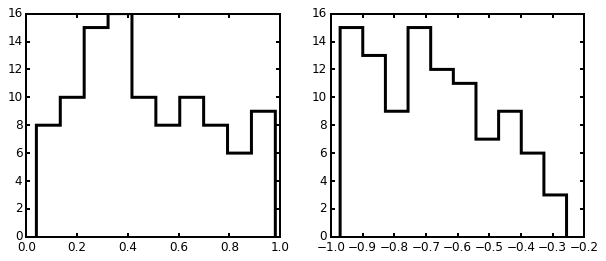

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,4))
hist_kwargs = dict(histtype='step', lw=3, color='k')
axes[0].hist(posterior[0][0], **hist_kwargs);
axes[1].hist(posterior[0][1], **hist_kwargs);


In [8]:
pmc_posterior = pmc_abc(model, data, epsilon_0=0.2, min_samples=100, steps=10, verbose=True)

Starting step 0
50 samples accepted (50.0%).
85 samples accepted (42.5%).
Error!  fB=9.00996626778e-05, beta=-0.0601763669195
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 243, in basic_abc
    synthetic_summary_stats = model.summary_stats(synthetic_data)
  File "<ipython-input-5-51e7081ccc92>", line 40, in summary_stats
    N = len(data)
TypeError: object of type 'NoneType' has no len()

Starting step 1
49 samples accepted (49.0%).
Starting step 2
Error!  fB=0.00107201616328, beta=-0.974724863486
Error generating data!
Traceback (most recent call last):
  File "../simpleabc/simple_abc.py", line 243, in basic_abc
    synthetic_summary_stats = model.summary_stats(synthetic_data)
  File "<ipython-input-5-51e7081ccc92>", line 40, in summary_stats
    N = len(data)
TypeError: object of type 'NoneType' has no len()

35 samples accepted (35.0%).
70 samples accepted (35.0%).
Starting step 3
Error!  fB=0.00337518417805, beta=-1.11879700271


In [9]:
pmc_posterior.shape

(10,)

In [10]:
pmc_posterior[-1]['epsilon']

0.068507644952146035

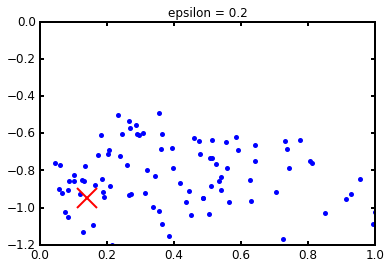

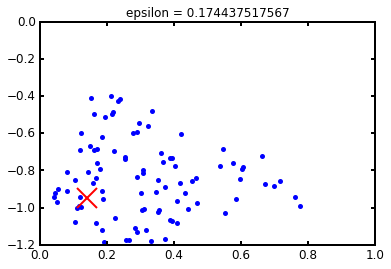

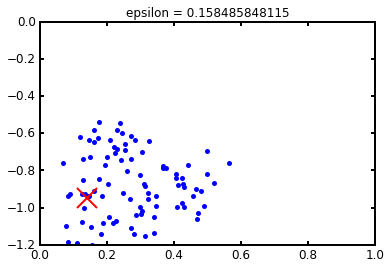

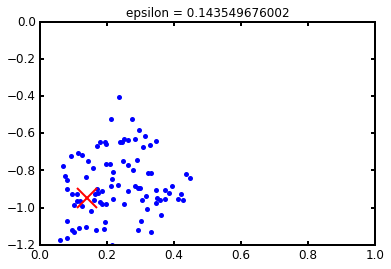

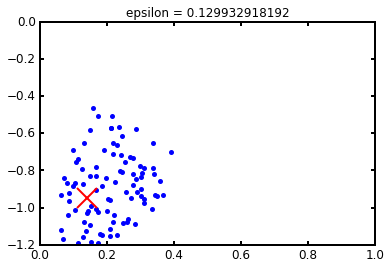

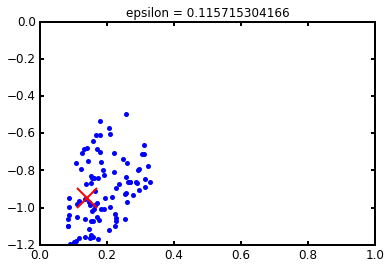

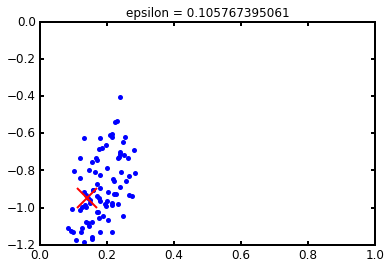

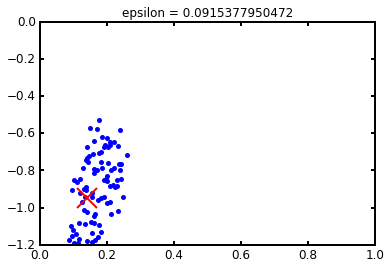

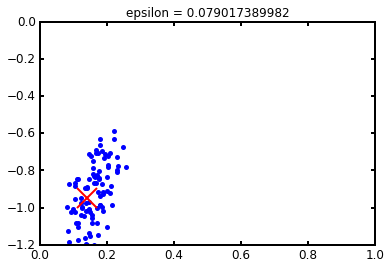

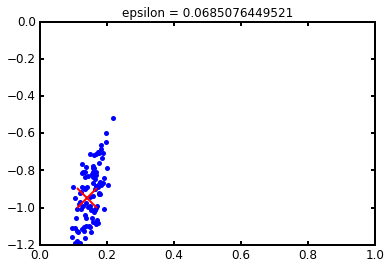

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(pmc_posterior.shape[0]):
    plt.figure()
    plt.plot(pmc_posterior[i][0][0,:], pmc_posterior[i][0][1,:], '.');
    plt.title('epsilon = {}'.format(pmc_posterior[i]['epsilon']))
    plt.plot(0.14, -0.95, 'rx', ms=20)
    plt.xlim(0,1)
    plt.ylim(-1.2, 0)

In [12]:
model.data.columns

Index([u'host', u'period', u'n_pri', u'logd_pri', u'dur_pri', u'slope_pri',
       u'snr_pri', u'n_sec', u'logd_sec', u'dur_sec', u'slope_sec', u'snr_sec',
       u'phase_sec'],
      dtype='object')

In [13]:
model.data.to_hdf('test_catalog.h5','df')

OK, let's try an MCMC to calculate the actual posterior here, which we can do.

$$\theta = (f_B, \beta)$$
$$\Gamma_\theta = f_B * 

In [15]:
model.period_min, model.period_max

(20, 1200)

In [16]:
model.bounds

[(0, 1), (-1.5, 0)]

In [18]:
targets[['radius', 'mass']].describe()

,radius,mass
count,39626.000000,39626.000000
mean,0.879247,0.876959
std,0.130112,0.126328
min,0.372000,0.400000
25%,0.794000,0.790000
50%,0.882000,0.890000
75%,0.974000,0.980000
max,1.150000,1.220000


In [19]:
from exosyspop.utils import semimajor, RSUN, AU

Rmean = targets.radius.mean()
Mmean = targets.mass.mean()

def pr_eclipse(period):
    """Approximate eclipse probability for period in days
    
    1.5*Rmean / amean(assuming mass=1.5*Mmena)
    """
    a = semimajor(period, Mmean*1.5)
    return 1.5*Rmean*RSUN/(a*AU)

In [22]:
pr_eclipse(200)

0.008360407404881141

In [66]:
data = pd.read_hdf('test_catalog.h5')
period_rng = (20, 1200)

def population_model(theta, period):
    fB, beta = theta
    v = fB * np.ones_like(period)
    beta1 = beta+1
    v *= period**beta*beta1 / (period_rng[1]**beta1 - period_rng[0]**beta1)
    return v
    
period_grid = np.linspace(period_rng[0], period_rng[1], 1000)
pr_ecl_grid = pr_eclipse(period_grid)
pr_ecl_data = pr_eclipse(data.period)
def lnlike(theta):
    pop = population_model(theta, period_grid) * pr_ecl_grid
    norm = np.trapz(pop, period_grid)
    #print(norm)
    ll = np.sum(np.log(population_model(theta, data.period) * pr_ecl_data)) - norm
    return ll if np.isfinite(ll) else -np.inf

bounds = [(0,1), (-1.5,0)]
def lnprob(theta):
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)
    

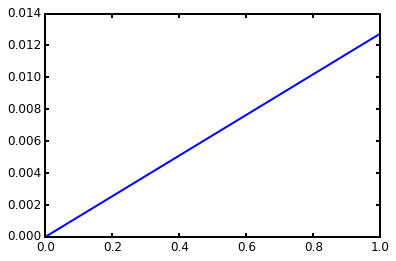

In [64]:
def lhood_norm(theta):
    pop = population_model(theta, period_grid) * pr_ecl_grid
    return np.trapz(pop, period_grid)

fB_grid = np.linspace(0,1,100)
beta_grid = np.linspace(-1.5,0,101)
norms = [lhood_norm([fB, -0.95]) for fB in fB_grid]
#norms = [lhood_norm([0.2, b]) for b in beta_grid]
plt.plot(fB_grid, norms)
#plt.plot(beta_grid, norms)

In [67]:
for fB, beta in zip(np.linspace(0,1,20), np.ones(20)*-0.95):
    print(fB, beta, lnprob([fB, beta]))

(0.0, -0.94999999999999996, -inf)
(0.052631578947368418, -0.94999999999999996, -1485.5585479173517)
(0.10526315789473684, -0.94999999999999996, -1404.4609985792922)
(0.15789473684210525, -0.94999999999999996, -1357.0222517180905)
(0.21052631578947367, -0.94999999999999996, -1323.3641200286856)
(0.26315789473684209, -0.94999999999999996, -1297.2569953123775)
(0.31578947368421051, -0.94999999999999996, -1275.9260439549382)
(0.36842105263157893, -0.94999999999999996, -1257.8910852026027)
(0.42105263157894735, -0.94999999999999996, -1242.2685830529874)
(0.47368421052631576, -0.94999999999999996, -1228.4886386686442)
(0.52631578947368418, -0.94999999999999996, -1216.1621291241324)
(0.57894736842105265, -0.94999999999999996, -1205.0115088744803)
(0.63157894736842102, -0.94999999999999996, -1194.8318485541477)
(0.68421052631578938, -0.94999999999999996, -1185.4675225437977)
(0.73684210526315785, -0.94999999999999996, -1176.7975605892661)
(0.78947368421052633, -0.94999999999999996, -1168.72606